## 导入包和数据

In [3]:
from VE_LSH import LSH
from CF import CF
from vector_encrypt import vector_encrypt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from laplace_dp import laplace_dp
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

original_data = pd.read_table('../GIS_LSH_VE_CF/data/train.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
user_mx = pd.read_table('../GIS_LSH_VE_CF/data/user_mx.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
test_data = pd.read_table('../GIS_LSH_VE_CF/data/new_test.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
attack_data = pd.read_table('../GIS_LSH_VE_CF/data/attack_data.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
noisy_user_mx = pd.read_table('../GIS_LSH_VE_CF/data/noisy_data_user_mx.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
data = test_data.groupby(test_data.index).mean()
# data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,0,0
# data = pd.read_table('./GIS_LSH_VE_CF/data/predict_data.csv',sep=",",names=['latitude','longitude','predict_latitude','predict_longitude','la_MAE','long_MAE'],encoding='latin-1',engine='python')
# print(data)
# 对用户矩阵进行预处理，将str转换为list
def to_list(str):
    return [ float(x) for x in str[1:-2].split(',')]
user_mx['latitude'] = user_mx['latitude'].apply(to_list)
user_mx['longitude'] = user_mx['longitude'].apply(to_list)
noisy_user_mx['latitude'] = noisy_user_mx['latitude'].apply(to_list)
noisy_user_mx['longitude'] = noisy_user_mx['longitude'].apply(to_list)

## 训练函数

In [4]:
def train_LSH(test_data,te_lshTable,lshTable,dp_lsh=False,is_laplace = False,is_pailiier=False): 
    global data,lsh_cal
    testIndex = test_data.index
    topk,count,length,num = 3,0,len(testIndex),-1
    # print("测试集LSH为:",lsh_cal.lsh_detect(te_lshTable))
    # print("训练集集LSH为:",lsh_cal.lsh_detect(lshTable))
    start_time = time.time()
    for table_num in te_lshTable.values(): # 遍历测试集的每个表,这里默认设置的一个表
        num += 1
        print("当前表数为:",num)
        for buckets in table_num: # 遍历当前表的hash桶
            if buckets not in lshTable[num].keys():
                    continue
            for test_id in te_lshTable[num][buckets]: # 遍历当前表当前桶里的测试集用户和训练集用户
                count += 1
                #print("当前进度是:",count/length)
                sim_lis = []
                
                for train_id in lshTable[num][buckets]: # 遍历训练集hash映射后同一个表，同一个桶下的数据
                    sim_lis.append(lsh_cal.calSim(test_id,train_id,is_laplace,is_pailiier))
                te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[2:topk]
                lsh_cal.lsh_mae(test_id,te)
    end_time = time.time()
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    if(dp_lsh):
        mean_mae = (la_mae+long_mae)/2 + np.random.laplace(0, 1/10, 1)
    else:
         mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,end_time-start_time

In [5]:
def train_CF(train_data,test_data):
    global data,cf_cal
    trainIndex,testIndex,topk,count = train_data.index,test_data.index,3,0
    length = len(testIndex)
    start_time = time.time()
    for i in testIndex:
        count += 1
        #print("当前进度是:",count/length)
        sim_lis = []
        for j in trainIndex:
            if i == j:
                continue
            sim_lis.append(cf_cal.calSim(i,j))
        te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[1:topk]
        cf_cal.cf_mae(i,te)
    end_time = time.time()
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,end_time-start_time

In [6]:
def train_encrypt_LSH(test_data,te_lshTable,lshTable):
    global data,lsh_cal
    testIndex = test_data.index
    topk,count,length,num = 3,0,len(testIndex),-1
    # print("测试集LSH为:",lsh_cal.lsh_detect(te_lshTable))
    # print("训练集集LSH为:",lsh_cal.lsh_detect(lshTable))
    res_time = 0
    start_time = time.time()
    for table_num in te_lshTable.values(): # 遍历测试集的每个表,这里默认设置的一个表
        num += 1
        print("当前表数为:",num)
        for buckets in table_num: # 遍历当前表的hash桶
            if buckets not in lshTable[num].keys():
                    continue
            for test_id in te_lshTable[num][buckets]: # 遍历当前表当前桶里的测试集用户和训练集用户
                count += 1
                #print("当前进度是:",count/length)
                sim_lis = []
                end_time = time.time()
                res_time += end_time-start_time
                for train_id in lshTable[num][buckets]: # 遍历训练集hash映射后同一个表，同一个桶下的数据
                    sim_res,time_count = lsh_cal.encrypt_calSim(test_id,train_id)
                    res_time += time_count
                    sim_lis.append(sim_res)
                start_time = time.time()
                te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[2:topk]
                lsh_cal.lsh_mae(test_id,te)
                end_time = time.time()
                res_time += end_time-start_time
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,res_time

# 隐私保护性能对比

## 参数和实例化

In [7]:
data_item = [10000]
attack_data_item = [1000,2000,3000,4000,5000]
# 参数设置
mae,times = [],[]
nbits,num,d = 20,2,2
# 实例化
vec_encrypt = vector_encrypt()
laplaceDP = laplace_dp()
lsh_cal = LSH(noisy_user_mx,data,vec_encrypt,laplaceDP)
cf_cal = CF(noisy_user_mx,data)
times = {}
bits_dic = {}
hash_func = lsh_cal.hash_function(num,nbits,d) # hash映射函数
for i in range(4):
    bits_dic[i],times[i] = [],[]

## Pailler_LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0, 0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:10000]
    df2 = attack_data.iloc[0:i]
    train_data = pd.concat([df1,df2]) # 拼接恶意数据
    cf_mean_mae,cf_time = train_CF(train_data,test_data)
    total_time += cf_time
    bits_dic[0].append(cf_mean_mae),times[0].append(total_time)

## LDP_LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:2000]
    df2 = attack_data[0:i]
    train_data = pd.concat([df1,df2])
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,False,True)
    total_time += lsh_time
    bits_dic[1].append(lsh_mae),times[1].append(total_time)

当前数据切片是: 1000
当前表数为: 0
当前表数为: 1
测试集long_mae为14.036087378419504,测试集la_mae为5.7017482207785,测试集mean_mae为9.868917799599002
当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为21.255492468629498,测试集la_mae为5.662689504179,测试集mean_mae为13.459090986404249
当前数据切片是: 3000
当前表数为: 0
当前表数为: 1
测试集long_mae为20.3923908682955,测试集la_mae为6.1184432867369996,测试集mean_mae为13.255417077516249
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为19.161055868295502,测试集la_mae为6.371084402027,测试集mean_mae为12.76607013516125
当前数据切片是: 5000
当前表数为: 0
当前表数为: 1
测试集long_mae为20.6358074686295,测试集la_mae为6.587593151100998,测试集mean_mae为13.611700309865249


## DP_LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:2000]
    df2 = attack_data[0:i]
    train_data = pd.concat([df1,df2])
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num,True) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,True,False)
    total_time += lsh_time
    bits_dic[2].append(lsh_mae),times[2].append(total_time)

当前数据切片是: 1000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.9616824385864984,测试集la_mae为1.2685340001145,测试集mean_mae为[2.75101789]
当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6030532616799986,测试集la_mae为1.2057214999794998,测试集mean_mae为[2.356769]
当前数据切片是: 3000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6030532616799986,测试集la_mae为1.2057214999794998,测试集mean_mae为[2.28968741]
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6030532616799986,测试集la_mae为1.2057214999794998,测试集mean_mae为[2.3486694]
当前数据切片是: 5000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6030532616799986,测试集la_mae为1.2057214999794998,测试集mean_mae为[2.33653388]


## IVE_LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:2000]
    df2 = attack_data[0:i]
    train_data = pd.concat([df1,df2])
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_encrypt_mae,lsh_encrypt_time = train_encrypt_LSH(test_data,te_lshTable,lshTable)
    total_time += lsh_encrypt_time
    bits_dic[3].append(lsh_encrypt_mae),times[3].append(total_time)


当前数据切片是: 1000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.9616824385864993,测试集la_mae为1.2685340001144996,测试集mean_mae为2.6151082193504993
当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.8625932616800003,测试集la_mae为1.2627470918244998,测试集mean_mae为2.56267017675225
当前数据切片是: 3000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.535910002014,测试集la_mae为1.2556450171745,测试集mean_mae为2.39577750959425
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.535910002014,测试集la_mae为1.198638936338,测试集mean_mae为2.367274469176
当前数据切片是: 5000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.535910002014,测试集la_mae为1.189902903858,测试集mean_mae为2.362906452936


In [ ]:
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

各个算法的误差为:{0: [5.56879908936469, 5.482257565940187, 5.378909471400462, 5.240299654215233, 4.878152217964743], 1: [9.868917799599002, 13.459090986404249, 13.255417077516249, 12.76607013516125, 13.611700309865249], 2: [array([2.71442573]), array([5.01256414]), array([4.5538412]), array([5.16990855]), array([4.29313258])], 3: [2.91873576706175, 5.14506876718725, 4.64570584055425, 4.904339167984249, 4.3894811548542485]}
各个所用的时间为{0: [109.09479355812073, 223.68772530555725, 355.80136609077454, 535.0890393257141, 717.1240408420563], 1: [6.067997455596924, 6.396330833435059, 6.914762735366821, 7.562108516693115, 8.28861141204834], 2: [5.960101127624512, 6.199551343917847, 6.594921588897705, 7.129825830459595, 7.728243589401245], 3: [7.2431135177612305, 7.61117959022522, 8.12549877166748, 8.76524305343628, 9.639248371124268]}


In [ ]:
leg = []
data_item = ['10%','20%','30%','40%','50%']
leg.append("Paillier_CF"),leg.append("LDP_LSH"),leg.append("FRec_LSH"),leg.append("IVE_LSH")
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

style = ["*","o","^","s","X","<",">","p","h","1","2"]
plt.figure(1 , figsize = (7 , 3) )
for i in range(4):
    plt.plot(data_item,bits_dic[i],color='k',marker=style[i],markersize=9,markerfacecolor='none')
plt.xlabel("恶意数据占比",fontsize=14),plt.ylabel("MAE",fontsize=14),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/bw_picture//attack_cmp_mae.jpg', bbox_inches='tight', pad_inches=0,dpi=500)

plt.figure(2 , figsize = (7 , 3) )
for i in range(4):
    plt.plot(data_item,times[i],color='k',marker=style[i],markersize=9,markerfacecolor='none')
plt.xlabel("恶意数据占比",fontsize=14),plt.ylabel("时间",fontsize=14),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/bw_picture//attack_cmp_time.jpg',bbox_inches='tight', pad_inches=0,dpi=500)
plt.show()

各个算法的误差为:{0: [6.255818920201389, 6.068192853773357, 5.712800743332887, 5.24988997912535, 4.8929030738736925], 1: [5.184470749225724, 2.72528981120675, 1.7148116514201748, 1.2762809388913499, 0.9955994893514999], 2: [array([5.40186584]), array([4.67849389]), array([4.43627639]), array([4.09183503]), array([3.66839446])], 3: [5.6137829898908755, 5.1987597207619, 4.77426144812355, 4.34730416765655, 3.9694839137328497]}
各个所用的时间为{0: [2004.5645380020142, 4028.8024406433105, 6072.816443681717, 8064.444778203964, 10025.005819797516], 1: [627.5705826282501, 1192.843421459198, 1736.0913791656494, 2212.7878003120422, 2639.875956296921], 2: [509.7284643650055, 963.6719717979431, 1374.0030553340912, 1747.7923092842102, 2054.6035828590393], 3: [621.3995916843414, 1184.1282932758331, 1700.0774335861206, 2154.1801013946533, 2536.650682926178]}


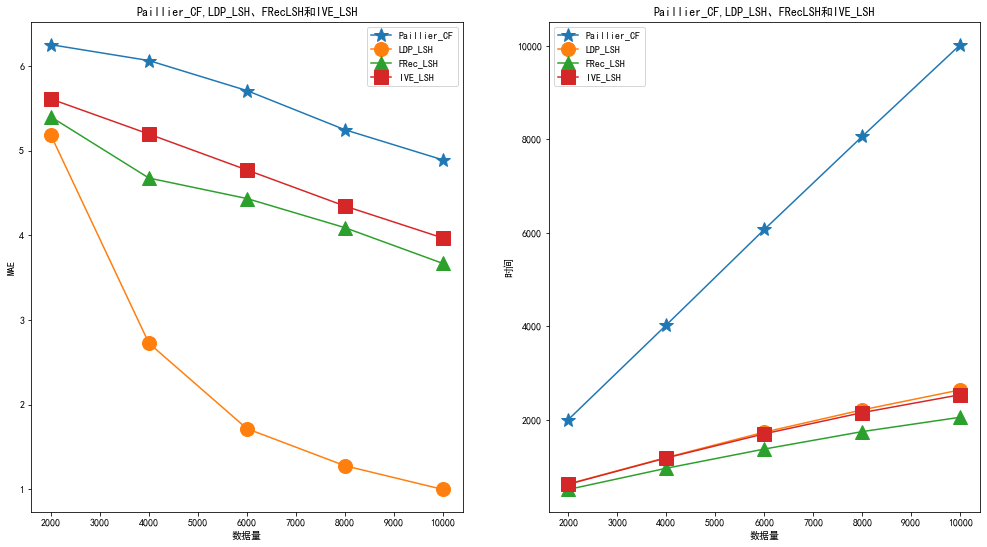

In [ ]:
leg = []
leg.append("Paillier_CF"),leg.append("LDP_LSH"),leg.append("FRec_LSH"),leg.append("IVE_LSH")
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

style = ["*","o","^","s","X","<",">","p","h","1","2"]
plt.figure(1 , figsize = (17 , 9) )
plt.subplot(121)
for i in range(4):
    plt.plot(data_item,bits_dic[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("MAE"),plt.title("Paillier_CF,LDP_LSH、FRecLSH和IVE_LSH"),plt.legend(leg)

plt.subplot(122)
for i in range(4):
    plt.plot(data_item,times[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("时间"),plt.title("Paillier_CF,LDP_LSH、FRecLSH和IVE_LSH"),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/picture//attack_cmp.jpg',dpi=500)
plt.show()

# 推荐效果性能对比

## 参数和实例化

In [ ]:
data_item = [2000,4000,6000,8000,10000]
attack_data_item = [1000,2000,3000,4000,5000]
# 参数设置
mae,times = [],[]
nbits,num,d = 20,2,2
# 实例化
vec_encrypt = vector_encrypt()
laplaceDP = laplace_dp()
lsh_cal = LSH(user_mx,data,vec_encrypt,laplaceDP)
cf_cal = CF(user_mx,data)
times = {}
bits_dic = {}
hash_func = lsh_cal.hash_function(num,nbits,d) # hash映射函数
for i in range(5):
    bits_dic[i],times[i] = [],[]

## Pailler_LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,False,False,True)
    total_time += lsh_time
    bits_dic[0].append(lsh_mae),times[0].append(total_time)
    start = 0

## 加入laplace噪声LDPLSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,False,True)
    total_time += lsh_time
    bits_dic[1].append(lsh_mae),times[1].append(total_time)
    start = 0

当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为8.1975968110865,测试集la_mae为2.5509429934759997,测试集mean_mae为5.37426990228125
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.227336641780002,测试集la_mae为1.2672611038100003,测试集mean_mae为2.747298872795001
当前数据切片是: 6000
当前表数为: 0
当前表数为: 1
测试集long_mae为2.7281463124145016,测试集la_mae为0.8606466250935004,测试集mean_mae为1.794396468754001
当前数据切片是: 8000
当前表数为: 0
当前表数为: 1
测试集long_mae为2.0641143462760017,测试集la_mae为0.681687955219,测试集mean_mae为1.3729011507475009
当前数据切片是: 10000
当前表数为: 0
当前表数为: 1
测试集long_mae为1.621973697604001,测试集la_mae为0.5475665154930001,测试集mean_mae为1.0847701065485005


## DP_LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num,True) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,True,False)
    total_time += lsh_time
    bits_dic[2].append(lsh_mae),times[2].append(total_time)
    start = 0

## LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,True,False)
    total_time += lsh_time
    bits_dic[3].append(lsh_mae),times[3].append(total_time)
    start = 0

当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.238755866682498,测试集la_mae为1.5158812750790003,测试集mean_mae为[2.20951006]
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6018015728179984,测试集la_mae为1.8833439232185003,测试集mean_mae为[2.71740851]
当前数据切片是: 6000
当前表数为: 0
当前表数为: 1
测试集long_mae为5.6434879858525,测试集la_mae为2.6152091586099995,测试集mean_mae为[4.16912941]
当前数据切片是: 8000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.597243807345501,测试集la_mae为2.1573339788239996,测试集mean_mae为[3.40411053]
当前数据切片是: 10000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.459685702815002,测试集la_mae为2.0135778412729994,测试集mean_mae为[3.32092577]


## IVE_LSH

In [ ]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_encrypt_mae,lsh_encrypt_time = train_encrypt_LSH(test_data,te_lshTable,lshTable)
    total_time += lsh_encrypt_time
    bits_dic[4].append(lsh_encrypt_mae),times[4].append(total_time)
    start = 0


当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.2387558666824985,测试集la_mae为1.5158812750790003,测试集mean_mae为2.3773185708807496
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6018015728179984,测试集la_mae为1.8833439232185,测试集mean_mae为2.742572748018249
当前数据切片是: 6000
当前表数为: 0
当前表数为: 1
测试集long_mae为5.6436357812415,测试集la_mae为2.6151856422160007,测试集mean_mae为4.129410711728751
当前数据切片是: 8000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.597243807345501,测试集la_mae为2.157333978824,测试集mean_mae为3.3772888930847507
当前数据切片是: 10000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.459718812428002,测试集la_mae为2.0135680004845,测试集mean_mae为3.236643406456251


In [ ]:
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

各个算法的误差为:{0: [3.2340515302575232, 2.1555268101756493, 1.4143286523437713, 1.2754302844482155, 1.1788079897819674], 1: [7.604682872577749, 8.46549705312475, 6.047936261091, 7.51617689722525, 7.578935485745], 2: [array([2.200402]), array([2.72186045]), array([4.23943268]), array([3.61333815]), array([3.16939218])], 3: [array([2.20951006]), array([2.71740851]), array([4.16912941]), array([3.40411053]), array([3.32092577])], 4: [2.3773185708807496, 2.742572748018249, 4.129410711728751, 3.3772888930847507, 3.236643406456251]}
各个所用的时间为{0: [24.267566204071045, 86.87246918678284, 180.4508924484253, 311.7095983028412, 461.65535163879395], 1: [4.598752975463867, 12.849329948425293, 25.822838306427002, 43.47468614578247, 64.43612813949585], 2: [3.534115791320801, 10.698094606399536, 21.260474681854248, 37.442036867141724, 57.49390721321106], 3: [4.740544080734253, 17.424986839294434, 37.79577302932739, 66.24986433982849, 101.44799613952637], 4: [5.208545207977295, 14.165765523910522, 28.398352146

In [ ]:
leg = []
leg.append("Paillier_LSH"),leg.append("LDP_LSH"),leg.append("DP_LSH"),leg.append("LSH"),leg.append("IVE_LSH")
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

style = ["*","o","^","s","X","<",">","p","h","1","2"]
plt.figure(1 , figsize = (17 , 9) )
plt.subplot(121)
for i in range(5):
    plt.plot(data_item,bits_dic[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("MAE"),plt.title("LDP_LSH、FRecLSH和LSH"),plt.legend(leg)

plt.subplot(122)
for i in range(5):
    plt.plot(data_item,times[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("时间"),plt.title("LDP_LSH、FRecLSH和LSH"),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/picture//CF_LSH_ELSH111.jpg',dpi=500)
plt.show()